# 要求

- 輸入(已知外生變數) :
    - (1) 買權還是賣權 - 變數符號 : call_put
    - (2) 選擇權目前市價 - 變數符號 : option_market_price
    - (3) 標的資產目前市價 - 變數符號 : s
    - (4) 選擇權履約價 - 變數符號 : k
    - (5) 選擇權到期日 - 變數符號 : t (單位 : 年)
    - (6) 無風險利率 - 變數符號 : r
    - (7) 搜尋的波動度上界 - 變數符號 : volatility_upperbond
    - (8) 容許誤差大小 - 變數符號 : error
- 輸出 : 隱含波動度  

# 作法概念

- 由於Black-Scholes(BS) Model反函數不存在，無法直接透過反函數求得隱含波動度
- 因此改用 : 找一個波動度，使其計算出來的選擇權理論價值和選擇權市價相同，則該波動度即為隱含波動度
- 上述方法有個問題 : 波動度為大於0的任意實數，可能數值有無限多個，未必能找到對應的
- 故給定一個誤差範圍，只要一個波動度對應的誤差落在範圍內就停止繼續搜尋，並回傳該波動度
- 由於可能波動度的有無限個，故無法只用迴圈(for，while)來搜尋
- 故改用「二分法」進行搜尋 ( 要驗證是否滿足使用條件 )

# 導入套件

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from scipy.stats import norm

# Step 1  定義「買權和賣權」函數 
- 事先給定的波動度 : volatility 

In [2]:
def calculator_call(s, k, r, t, volatility) :
    d1 = ( np.log(s/k) + (r + (volatility**2/2) )*t ) / (volatility*np.sqrt(t) )
    d2 = d1 - volatility*np.sqrt(t)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    call_model_price = s*N_d1 - k*np.exp(-r*t)*N_d2
    return call_model_price

def calculator_put(s, k, r, t, volatility) :
    d1 = ( np.log(s/k) + (r + (volatility**2/2) )*t ) / (volatility*np.sqrt(t) )
    d2 = d1 - volatility*np.sqrt(t)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    put_model_price = k*np.exp(-r*t)*( 1 - N_d2 ) - s*( 1 - N_d1 )
    return put_model_price

# Step 2 定義「二分法」函數

In [3]:
def bianry_search(call_put, option_market_price, s, k, t, r, volatility_upperbond, error) :
        
    #  選擇權類型函數  #
    
    option_calcualte_funcs = { 'call':calculator_call,     # 用途見「設定二分法參數初始值」這個區塊
                               'put':calculator_put
                             }
    #  設定二分法參數初始值  #
    
    volatility_lowerbond = 0   # volatility的數值是由0~volatility_upperbond，是天生就已經進行排序的，其數值大小等同排序後的大小
                               # 因此，可以不用透過index去搜尋，volatility本身的大小即反映其index的大小
        
    volatility_upperbond = volatility_upperbond   
    mid_volatility = ( volatility_lowerbond + volatility_upperbond ) / 2
    mid_option_value = option_calcualte_funcs[call_put](s, k, r, t, mid_volatility)
                        # 若使用者輸入「call」，則 option_calcualte_funcs[call_put] = calculator_call
                        # 若使用者輸入「put」，則 option_calcualte_funcs[call_put] = calculator_put
                        # 這樣寫較簡潔，否則要用「if和else」分別計算輸入call和put之情況
                
    current_error = abs( ( mid_option_value - option_market_price ) / option_market_price ) 
                        # 將誤差轉為比率可不受資料數值規模影響
                                                                      
    number_of_searches = 0   # 用於計算搜尋次數 ( 後面可用於查看搜尋過程與保護機制 )
    
    #  開始迴圈  #
    
    while not ( current_error <= error) :   # 只要目前誤差大於可容許誤差，便執行以下迴圈
        
        number_of_searches += 1   # 每次進入迴圈便+1
            
        ##  用於查看搜尋過程  ##
            
        print(f'第{number_of_searches:,}次搜尋', end = '  ')
        print(f'option market price = { round(option_market_price,3)}', end = '  ')   # 只呈現到小數點下第3位
        print(f'mid option value = { round(mid_option_value,3) }', end = '  ')
        print(f'volatility lower bond  = { round(volatility_lowerbond,3) }', end = '  ')
        print(f'volatility upper bond  = { round(volatility_upperbond,3) }')
            
            
        if option_market_price < mid_option_value :       # 若市價<中間價
            volatility_upperbond = mid_volatility         # 則將中間價對應之中間波動度改為波動度上界
        else : 
            volatility_lowerbond = mid_volatility         # 反之，若市價>中間價，則將中間價對應之中間波動度改為波動度下界
        
        mid_volatility = ( volatility_lowerbond + volatility_upperbond ) / 2  
        mid_option_value = option_calcualte_funcs[call_put](s, k, r, t, mid_volatility)           
        current_error = abs( ( mid_option_value - option_market_price ) / option_market_price )
                        # 這三行程式碼無論輸入call或put都會執行，故將其方在判斷式(if,else)外，while迴圈內
            
         ## 保護機制  ##   
            
        if number_of_searches > 1000000 :     # 若搜尋次數大於1,000,000
            print('無法搜尋到隱含波動度')       # 則告訴我找不到
            mid_volatility = -1               # 並隨意給 mid_volatility一個數值避免 return報錯
            break                             # 最後終止迴圈
            
    #  迴圈結果  #        
                        
    implied_volatility = mid_volatility    # 不論是輸入call或put，
                                           # 當迴圈順利結束時，implied_volatility 皆等於 mid_volatility

    return implied_volatility 

# Step 3 使用者輸入參數

In [4]:
call_put = input('請輸入要計算「call」還是「put」: ')    # 透過input所輸入的東西，資料型態皆為str，故需依參數資料型態的不同進行轉換
option_market_price = float( input('選擇權目前市價 = ') )         # 選擇權市價 : float
s = float( input('選擇權之標的資產目前市價 = ') )                  # 標的資產市價 : float
k = float( ( input('選擇權之履約價 = ') ) )                       # 履約價 : float
t = float( input('選擇權之到期日(單位:年) = ') )                   # 到期日 : float
r = float( input('目前無風險利率 = ') )                           # 無風險利率 : float
volatility_upperbond = float( input('搜尋的波動度上界 = ') )      # 波動度上界 : float
error = float( input('容許誤差大小 = ') )                         # 容許誤差大小 : float

請輸入要計算「call」還是「put」: call
選擇權目前市價 = 10
選擇權之標的資產目前市價 = 100
選擇權之履約價 = 150
選擇權之到期日(單位:年) = 0.25
目前無風險利率 = 0.05
搜尋的波動度上界 = 10
容許誤差大小 = 0.000001


# Step 4 輸出結果

In [5]:
ans = bianry_search(call_put, option_market_price, s, k, t, r, volatility_upperbond, error)
print('\n')
print('implied volatility =',ans)

第1次搜尋  option market price = 10.0  mid option value = 74.472  volatility lower bond  = 0  volatility upper bond  = 10.0
第2次搜尋  option market price = 10.0  mid option value = 36.454  volatility lower bond  = 0  volatility upper bond  = 5.0
第3次搜尋  option market price = 10.0  mid option value = 11.92  volatility lower bond  = 0  volatility upper bond  = 2.5
第4次搜尋  option market price = 10.0  mid option value = 1.878  volatility lower bond  = 0  volatility upper bond  = 1.25
第5次搜尋  option market price = 10.0  mid option value = 6.302  volatility lower bond  = 0.625  volatility upper bond  = 1.25
第6次搜尋  option market price = 10.0  mid option value = 9.021  volatility lower bond  = 0.938  volatility upper bond  = 1.25
第7次搜尋  option market price = 10.0  mid option value = 10.453  volatility lower bond  = 1.094  volatility upper bond  = 1.25
第8次搜尋  option market price = 10.0  mid option value = 9.732  volatility lower bond  = 1.094  volatility upper bond  = 1.172
第9次搜尋  option market price = 1

# Step 5 驗證是否滿足使用二分法之前提條件
- 畫圖驗證「波動度」和「選擇權價值」之關係是否滿足「單調函數」之條件

In [6]:
call_price_list = []    # 用於盛裝後面計算出來的一系列的 call, put, volatility
put_price_list = []
volatility_list = []

for i in np.arange(0,volatility_upperbond,0.001) :                       # volatility由 0 ~ 上界
    c = calculator_call(s=100, k=105, r=0.05, t=0.25, volatility=i)      # 間隔為0.001
    p = calculator_put(s=100, k=105, r=0.05, t=0.25, volatility=i)       # 一一代入公式計算出call和put之價格
    call_price_list.append(c)
    put_price_list.append(p)
    volatility_list.append(i)

data = pd.DataFrame( { 'Call Price' : call_price_list ,
                       'Put Price' : put_price_list ,
                       'Volatility' : volatility_list
                     }
                    )
data.set_index('Volatility', inplace = True)    # 將 Volatility 改為 index 方便畫圖

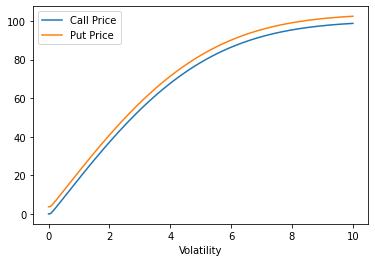

In [7]:
data.plot()

### 由上圖可知滿足「單調函數」之條件，故可使用二分法搜尋隱含波動度